In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
import models.cnn_autoencoder_model as cnnmodel
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
unet_model = tf.keras.models.load_model('saved_model/unet_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class,
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})

In [3]:
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot

53/53 [==============================] - 2s 6ms/step


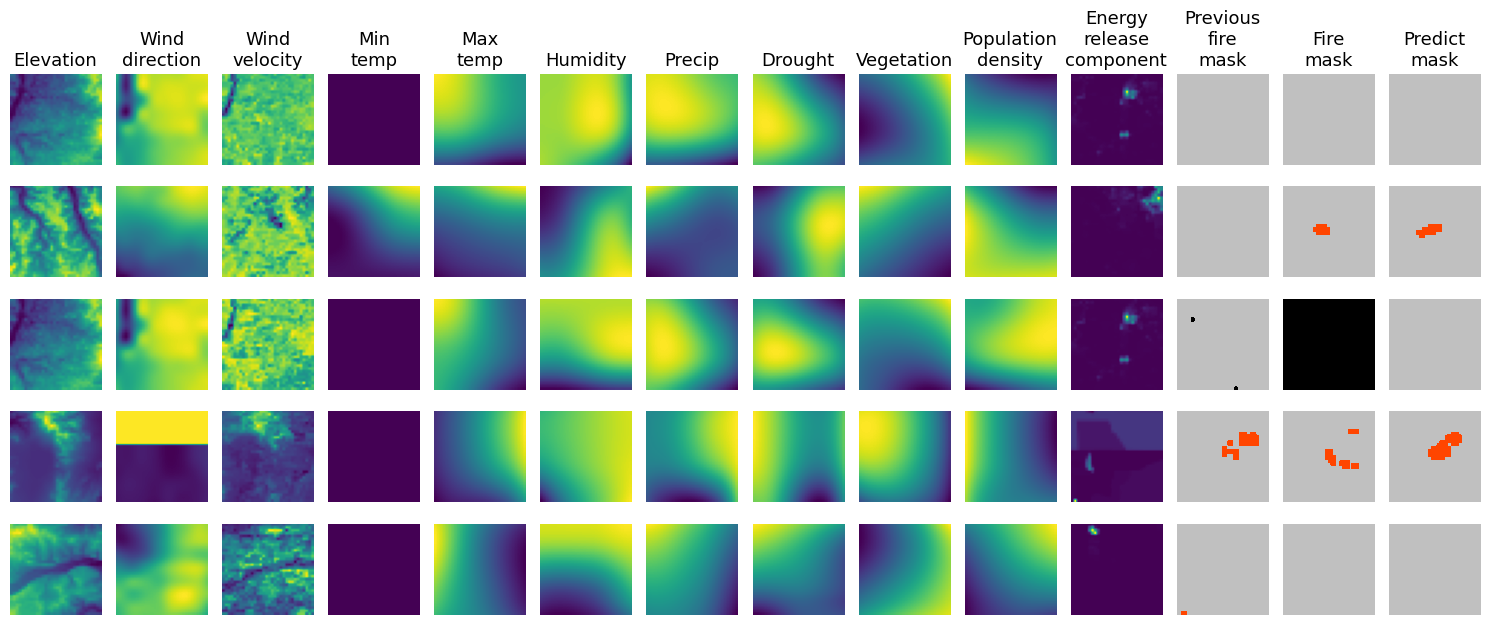

In [4]:
from matplotlib import colors
import matplotlib.pyplot as plt
hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': False,
    'center_crop': True,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)

features = []
labels = []
for feature, label in test_dataset:
    features.append(feature.numpy())
    labels.append(label.numpy())
all_features = tf.concat(features, axis=0)
all_labels = tf.concat(labels, axis=0)

logits = unet_model.predict(all_features)
y_pred = tf.math.sigmoid(logits)
#mask = tf.cast(tf.not_equal(all_labels, -1), tf.float32)
predictions = tf.cast(y_pred >= 0.5, 'int32')

TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predict\nmask',
]
# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = 12
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

inputs, labels = next(iter(test_dataset))

fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 2):
    plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
    if j == n_features + 1:
       plt.imshow(predictions[i, :, :, 0], cmap=CMAP, norm=NORM)
    plt.axis('off')
plt.tight_layout()

In [5]:
cls = 0
image =  inputs[0]
prop_from_layer = unet_model.layers[-1].name
prop_to_layer = 'conv2d_8'

## A. Seg-Grad-CAM for a pixel

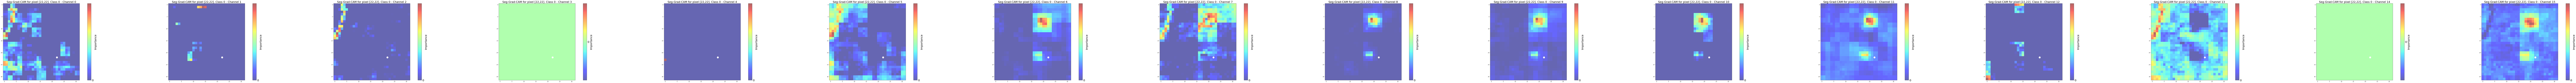

In [6]:
# create a SegGradCAM object
pixsgc = SegGradCAM(unet_model, image, cls,  prop_to_layer,prop_from_layer, roi=PixelRoI(22,22,image),
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc, unet_model, None, None)
# plot explanations on 1 picture
plotter.explainPixel()

## B. Seg-Grad-CAM for a class

1/1 [==============================] - 0s 17ms/step


Shape of RoI:  (32, 32)
Lengths of i and j index lists: 0 0


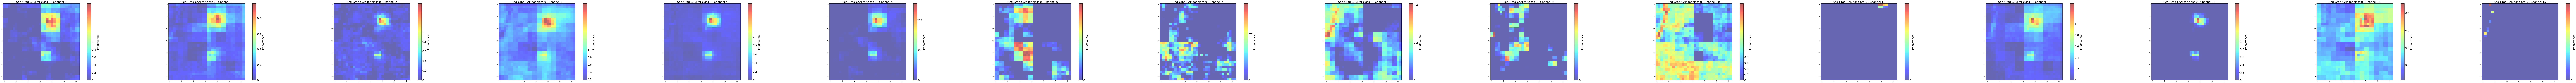

In [7]:
clsroi = ClassRoI(unet_model,image,cls)
clssgc = SegGradCAM(unet_model, image, cls,  prop_to_layer,prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, unet_model, None, None)
clsplotter.explainClass()